# NRSE simulations with correction coils

Sam McKay (samckay@iu.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
import mcstasscript as ms    #only needed for McStas

plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])

SMALL_SIZE = 35    #sets figure font size
MEDIUM_SIZE = 50
BIGGER_SIZE = 65

plot_height = 15    #plot size parameters
plot_width = plot_height*1.618
plt.rcParams['figure.figsize'] = (plot_width, plot_height)    #default plot size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)

plt.rcParams['axes.grid'] = False

plt.rc('text', usetex=True)    #additions to latex preamble for matplotlib:
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
plt.rcParams["font.family"] = "Computer Modern Roman"

my_configurator = ms.Configurator()    #adds McStas installation to path, only needs to be run once
my_configurator.set_mcrun_path("C:\\mcstas-3.1\\bin\\")
my_configurator.set_mcstas_path("C:\\mcstas-3.1\\lib\\")  
print(my_configurator)

Configurator:
 paths:
  mcrun_path: C:\mcstas-3.1\bin\
  mcstas_path: C:\mcstas-3.1\lib\
  mcxtrace_path: /Applications/McXtrace-1.5.app/Contents/Resources/mcxtrace/1.5/
  mxrun_path: /Applications/McXtrace-1.5.app/Contents/Resources/mcxtrace/1.5/bin/
 other:
  characters_per_line: 85



In [2]:
gN = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
mN = 1.674927e-27    #mass of neutron (kg)
hbar = 1.054571e-34    #plancks constant (kg m^2/s)
cL = gN/(hbar*2*np.pi)*mN*1e-10    #Larmor phase constant (T^-1 m^-1 AA^-1)
meV_to_J = 1.60218e-22    #converts meV to Joules

RF_dims = [0.04, 0.04, 0.15]    #dimensions of the RF flippers in meters (x,y,z)
CC_dims = [0.04, 0.04, 0.14]    #dimension of the correction coil in meters (x,y,z)

#Field integral expansion: FI = F0 + a y^2 + b z^2 + c yphi + d zpsi
F0_given = 0.0001685716    # T m / Amp
a_given = 0.0087755046    #T / Amp m
b_given = 0.0089702849
c_given = -0.0005253771    # T / Amp rad
d_given = 0.0009858967

def get_FI_const(wavelength):
    """Converts between Larmor phase and the field integral.
    Wavelength is in units of Angstroms."""
    return cL*wavelength

def get_scattering_angle(wavelength,q):
    """Returns scattering angle in DEGREES. The total scattered angle is theta, NOT 2*theta."""
    theta = 2*np.arcsin(wavelength*q/(4*np.pi))*180/np.pi
    return theta

def get_CC_currents(freq,c_d1,c_d2,c_d3,r_d1,r_d2):
    """Returns the required correction coil current (Amps) assuming proper focusing.
    Current is average of the vertical and horizontal focusing currents.
    Frequency must be given in MHz."""
    Enc = 2*np.pi*freq*1e6*abs(r_d1 - r_d2)/gN    #encoding term
    horz_cur = Enc/(c_d1 - c_d2)/(c_d1 - c_d3)/a_given
    vert_cur = Enc/(c_d1 - c_d2)/(c_d1 - c_d3)/b_given
    return (vert_cur + horz_cur)/2

Builds the beamline with the parameters given. 
We assume the RF flippers are perfect flippers; designed for use with the idealized RF flipper component "pol_RFaker.comp" which assumes a rectangular field region. WARNING: uses McStas version 3.1.

In [3]:
monochromatic = True    #time of flight NOT implemented yet

if (monochromatic):
    lambda0 = 8.0    #neutron wavelength (AA)
    dlambda = 1.0/100*lambda0    #wavelength spread (AA)
    print("Wavelength (AA): ", lambda0,)
    print("Wavelength spread (%): ", round(dlambda/lambda0*100,3), "\n")
else:
    lammin = 3.0
    lammax = 5.0
    Emax = (2*np.pi*hbar/(lammin*10**-10))**2/(2*mN)/meV_to_J    #upper limit of energy distribution (meV)
    Emin = (2*np.pi*hbar/(lammax*10**-10))**2/(2*mN)/meV_to_J
    Ec = Emax-.01    #parameters that define the flux profile 
    t0 = 30
    gamma = 1
    print("Wavelength range (AA): ", [round(i,3) for i in [lammin,lammax]], "\n")
    
ap_dia = 10.0    #aperture diameter (mm)
s_ill = 20.0    #side length of sample illumination square (mm)
print("Aperture diameter (mm): ", ap_dia)
print("Sample illumination square (mm): ", s_ill, "\n")

#Correction coil offsets (mm)
xscale, yscale, zscale, hascale, vascale = 0, 0, 0, 0, 0    #scales for randomization
xconst, yconst, zconst, haconst, vaconst = 0, 0, 0, 0, 0    #constant offsets for randomization
cc_xo = [round((i - .5)*xscale + xconst,5) for i in np.random.rand(6)]
cc_yo = [round((i - .5)*yscale + yconst,5) for i in np.random.rand(6)]
cc_zo = [round((i - .5)*zscale + zconst,5) for i in np.random.rand(6)]
cc_ha = [round((i - .5)*hascale + haconst,5) for i in np.random.rand(6)]
cc_va = [round((i - .5)*vascale + vaconst,5) for i in np.random.rand(6)]
print('CC x offsets (mm): ', cc_xo,)
print('CC y offsets (mm): ', cc_yo,)
print('CC z offsets (mm): ', cc_zo,)
print('CC horizontal angle offsets (deg): ', cc_ha)
print('CC vertical angle offsets (deg): ', cc_va, '\n')

print('-'*80)    #Sample parameters
x_s = 0.05    #dimensions of sample (m)
y_s = 0.05
z_s = 0.001    #TO DO: modify code to work with thicker samples
rho_b = 6e10    #scattering length density (1/cm^2)
vol_rat = 0.1    #volume fraction of spheres to solution
inco = 0.02    #incoherent background (1.0 water, 0.5 mixture, 0.02 D2O)
s_frac = 1.0    #probability of scattering (including isotropic incoherent part)
sans_frac = 1.0    #probability of SANS scattering between q_min and 1.0 A
single_scattering = 1    #probability of single scattering events
q_min = 0.00001    #q range of scattering (1/A)
q_max = 0.0055    #q_max=1.0 is maximum hard-coded value for SANS scattering, rest is incoherent background
R_s = 2*np.pi/(q_max + q_min)/2    #radius of spheres (AA)

print("Sample parameters (hard spheres in D2O):")
print("Q range (1/A): ", [q_min,q_max], "\n")
print("Scattering angle range for ", lambda0," AA neutrons (deg): ", \
      [round(get_scattering_angle(lambda0,i),5) for i in [q_min,q_max]], '\n')
print('-'*80)

L_d = 7.0    #distance from source to detector (m)

sep = CC_dims[2] + .01    #separation between an RF and CC in one vacuum chamber (m)
dcc1, dcc2, dcc3, dcc4, dcc5, dcc6 = 1.0, 2.0, 3.0, 4.0, 5.0, 6.0    #distances from source to correction coil
d1, d2, d3, d4 = dcc1 - sep, dcc3 + sep, dcc4 - sep, dcc6 + sep    #distances from source to flipper
d_s = 3.5    #sample is in the center of the two arms
dis = [d1,dcc1,dcc2,dcc3,d2,d_s,d3,dcc4,dcc5,dcc6,d4]
print("Distance from source: \t ", dis + [L_d], '\n')

Lcc1, Lcc2  = L_d - dcc1 - CC_dims[2]/2, L_d - dcc2 - CC_dims[2]/2    #distances from correction coils to detector
Lcc3, Lcc4 = L_d - dcc3 - CC_dims[2]/2, L_d - dcc4 - CC_dims[2]/2
Lcc5, Lcc6 = L_d - dcc5 - CC_dims[2]/2, L_d - dcc6 - CC_dims[2]/2
L1, L2 = L_d - d1 - RF_dims[2]/2, L_d - d2 - RF_dims[2]/2    #distances from flippers to detector
L3, L4 = L_d - d3 - RF_dims[2]/2, L_d - d4 - RF_dims[2]/2
L_s = L_d - d_s    #distance from sample to detector
disD = [L1,Lcc1,Lcc2,Lcc3,L2,L_s,L3,Lcc4,Lcc5,Lcc6,L4]
print("Distance from detector: ", [round(i,3) for i in ([L_d] + disD)], '\n')

f1 = 1.0    #frequency in first flipper (MHz)
f2, f3, f4 = f1, -f1, -f1    #NRSE focusing condition
freqs = [f1,f2,f3,f4]
print("RF frequencies (MHz): ", [round(i,5) for i in freqs], '\n')

#Assumes 1 MHz RF frequency
cur1 = get_CC_currents(f1,dcc1,dcc2,dcc3,d1,d2)    #Currents in the correction coils with focusing condition (amps)
cur2 = -2*cur1
cur3 = cur1
cur4 = get_CC_currents(f3,dcc4,dcc5,dcc6,d3,d4)    #first coil of the second arm (fourth overall)
cur5 = -2*cur4    #apply the focusing condition
cur6 = cur4
cur_arm1 = [cur1,cur2,cur3]
cur_arm2 = [cur4,cur5,cur6]
print("CC currents in arm 1 (Amps): ", [round(i,3) for i in cur_arm1])
print("CC currents in arm 2 (Amps): ", [round(i,3) for i in cur_arm2], '\n')

pol_dir = [1,0,0]    #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]    
print('Polarizer axis: ', [round(i,3) for i in pol_dir], '\n')

det_ff = 0.9
det_x = det_ff*2*(L_d*(ap_dia/2 + 1000*RF_dims[0]/2)/(dis[-1] + RF_dims[2]) - ap_dia/2)    #max detector size NO scattering (mm)
det_y = det_ff*2*(L_d*(ap_dia/2 + 1000*RF_dims[1]/2)/(dis[-1] + RF_dims[2]) - ap_dia/2)
#det_x = det_ff*2*(L_s*(s_ill/2 + 1000*RF_dims[0]/2)/(dis[-1] - d_s + RF_dims[2]) - s_ill/2)    #max detector size WITH scattering (mm)
#det_y = det_ff*2*(L_s*(s_ill/2 + 1000*RF_dims[1]/2)/(dis[-1] - d_s + RF_dims[2]) - s_ill/2)
det_bins = 64
center = (det_bins + 1)/2 - 1    #center bin of detector; assumes square detector with first bin as 0
delta_x = det_x / det_bins     #actual length of each bin (mm)
delta_y = det_y / det_bins
xmin, xmax = -det_x/2, det_x/2    #x detector cut width (mm)
ymin, ymax = -det_y/20, det_y/20    #x detector cut height (mm)
det_x_offset, det_y_offset, det_z_offset  = 0.0, 0.0, 0.0
print('Detector size (mm) = ', [round(i,3) for i in [det_x,det_y]])
print('[x,y] bin size (mm) = ', [round(i,3) for i in [det_x/det_bins,det_y/det_bins]])
print('Detector offsets (mm) = ', [det_x_offset, det_y_offset, det_z_offset], '\n')
if (not monochromatic):
    time_min = 1.1*L_d*np.sqrt(mN/(2*Emax*mev_to_J))*1e6    #time of fastest neutrons arriving at detector (us)
    time_max = 0.9*L_d*np.sqrt(mN/(2*Emin*mev_to_J))*1e6
    time_bins = 1024    #bin number for time of flight detector
    tb_width = (time_max - time_min)/time_bins    #time bin width (us)
    print("Time bin width (us): ", round(tb_width,3), '\n')

xy_filename = "\"xy.dat\""    #filenames and detector strings for nD detector component
if (not monochromatic):
    tof_filename =  "\"tof.dat\""
    PSD_tof_det_filename = "\"PSD_tof.dat\""
    PSD_tof_det_string = "\"signal=t, x bins=" + str(det_bins) + " limits=[" + str(xmin/1e3) + "," + str(xmax/1e3) + \
    "], y bins=" + str(det_bins) + " limits=[" + str(ymin/1e3) + "," + str(ymax/1e3) + "]\""
    sx_det_filename, sy_det_filename, sz_det_filename = "\"sx.dat\"", "\"sy.dat\"", "\"sz.dat\""
    sx_det_string = "\"signal=sx, t bins=" + str(time_bins) + " limits=[" + str(time_min/1e6) + "," + str(time_max/1e6) + "]\""
    sy_det_string = "\"signal=sy, t bins=" + str(time_bins) + " limits=[" + str(time_min/1e6) + "," + str(time_max/1e6) + "]\""
    sz_det_string = "\"signal=sz, t bins=" + str(time_bins) + " limits=[" + str(time_min/1e6) + "," + str(time_max/1e6) + "]\""
    
print("-"*80)     #Start of instrument definition
NRSE = ms.McStas_instr('CC_NRSE', author = 'Sam McKay', origin = 'Indiana University')
low_count = NRSE.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
rf_on = NRSE.add_parameter("int", "rf_on", value = 0, comment="if true turns on all flippers [N/A]")
arm1_on = NRSE.add_parameter("int", "arm1_on", value = 0, comment="if true turns on all correction coils in first arm [N/A]")
arm2_on = NRSE.add_parameter("int", "arm2_on", value = 0, comment="if true turns on all correction coils in second arm [N/A]")
sample_in = NRSE.add_parameter("int", "sample_in", value = 0, comment="if true moves the sample into the beam [N/A]")
ang_s = NRSE.add_parameter("double", "ang_s", value = 0.0, comment="angle of scattered beam [deg]")
cur1 = NRSE.add_parameter("double", "cur1", value = cur_arm1[0], comment="CC_1 current [Amps]")
cur2 = NRSE.add_parameter("double", "cur2", value = cur_arm1[1], comment="CC_2 current [Amps]")
cur3 = NRSE.add_parameter("double", "cur3", value = cur_arm1[2], comment="CC_3 current [Amps]")
cur4 = NRSE.add_parameter("double", "cur4", value = cur_arm2[0], comment="CC_4 current [Amps]")
cur5 = NRSE.add_parameter("double", "cur5", value = cur_arm2[1], comment="CC_5 current [Amps]")
cur6 = NRSE.add_parameter("double", "cur6", value = cur_arm2[2], comment="CC_6 current [Amps]")
freq1 = NRSE.add_parameter("double", "freq1", value = freqs[0], comment="RF_1 frequency [MHz]")
freq2 = NRSE.add_parameter("double", "freq2", value = freqs[1], comment="RF_2 frequency [MHz]")
freq3 = NRSE.add_parameter("double", "freq3", value = freqs[2], comment="RF_3 frequency [MHz]")
freq4 = NRSE.add_parameter("double", "freq4", value = freqs[3], comment="RF_4 frequency [MHz]")
ang1 = NRSE.add_parameter("double", "ang1", value = 0.0, comment="Horizontal angle of RF_1 [deg]") 
ang2 = NRSE.add_parameter("double", "ang2", value = 0.0, comment="Horizontal angle of RF_2 [deg]")
ang3 = NRSE.add_parameter("double", "ang3", value = 0.0, comment="Horizontal angle of RF_3 [deg]")
ang4 = NRSE.add_parameter("double", "ang4", value = 0.0, comment="Horizontal angle of RF_4 [deg]")
polx = NRSE.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = NRSE.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = NRSE.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
NRSE.show_parameters()

print('-'*80)    #Source and polarizer (collimation included via source parameters):
NRSE.add_component("origin", "Progress_bar")
NRSE.add_component("arm", "Arm", AT=[0,0,0], RELATIVE="origin")

if (monochromatic):
    src = NRSE.add_component("src", "Source_sam", AT=[0,0,0], RELATIVE="origin")
    src.set_parameters(radius=ap_dia/2e3, I1=1e12, lambda0=lambda0, dlambda=dlambda, focus_xw=s_ill/1e3, \
                       focus_yh=s_ill/1e3, x_offset=det_x_offset/1e3, dist=L_s)
    print(src)
else:
    src = NRSE.add_component("src", "Moderator", AT=[0,0,0], RELATIVE="origin")
    src.set_parameters(radius=ap_dia/2e3, flux=1e12, Emin=Emin, Emax=Emax, Ec=Ec, t0=t0, \
                       gamma=gamma, focus_xw=s_ill/1e3, focus_yh=s_ill/1e3, dist=L_s)
    print(src)
    
pol = NRSE.add_component("pol", "Set_pol", AT=[0,0,1e-9], RELATIVE="origin")
pol.set_parameters(px=polx, py=poly, pz=polz)
print(pol)

print('-'*80)    #First set of RF flippers and correction coils
rf1 = NRSE.add_component("rf1", "pol_RFaker", AT=[0,0,d1], RELATIVE="origin")
rf1.set_parameters(xwidth=RF_dims[0], yheight=RF_dims[1], zdepth=RF_dims[2], freq="freq1*rf_on")
rf1.set_ROTATED([0,ang1,0], RELATIVE="ABSOLUTE")
print(rf1)

cc1 = NRSE.add_component("cc1", "pol_CC_expansion_v4", AT=[cc_xo[0]/1e3, cc_yo[0]/1e3, dcc1 + cc_zo[0]/1e3], RELATIVE="origin")
cc1.set_parameters(xwidth=CC_dims[0], yheight=CC_dims[1], zdepth=CC_dims[2], current="cur1*arm1_on", balanced=0)
cc1.set_ROTATED([cc_ha[0], cc_va[0], 0], RELATIVE="ABSOLUTE")
print(cc1)

cc2 = NRSE.add_component("cc2", "pol_CC_expansion_v4", AT=[cc_xo[1]/1e3, cc_yo[1]/1e3, dcc2 + cc_zo[1]/1e3], RELATIVE="origin")
cc2.set_parameters(xwidth=CC_dims[0], yheight=CC_dims[1], zdepth=CC_dims[2], current="cur2*arm1_on", balanced=0)
cc2.set_ROTATED([cc_ha[1], cc_va[1], 0], RELATIVE="ABSOLUTE")
print(cc2)

cc3 = NRSE.add_component("cc3", "pol_CC_expansion_v4", AT=[cc_xo[2]/1e3, cc_yo[2]/1e3, dcc3 + cc_zo[2]/1e3], RELATIVE="origin")
cc3.set_parameters(xwidth=CC_dims[0], yheight=CC_dims[1], zdepth=CC_dims[2], current="cur3*arm1_on", balanced=0)
cc3.set_ROTATED([cc_ha[2], cc_va[2], 0], RELATIVE="ABSOLUTE")
print(cc3)

rf2 = NRSE.add_component("rf2", "pol_RFaker", AT=[0,0,d2], RELATIVE="origin")
rf2.set_parameters(xwidth=RF_dims[0], yheight=RF_dims[1], zdepth=RF_dims[2], freq="freq2*rf_on")
rf2.set_ROTATED([0,ang2,0], RELATIVE="ABSOLUTE")
print(rf2)

print('-'*80)    #Sample area. All future componenets are defined relative to the sample table
sample = NRSE.add_component("sample", "SANS_spheres2", AT=["1 - sample_in", 0, L_s-1e-9], RELATIVE="origin")
sample.set_parameters(xwidth=x_s, yheight=y_s, zthick=z_s, R=R_s, drho=rho_b, phi=vol_rat, dsdw_inc=inco, \
                      sc_aim=s_frac, sans_aim=sans_frac, singlesp=single_scattering, Qmind=q_min, Qmaxd=q_max)
print(sample)

sample_table = NRSE.add_component("sample_table","Arm", AT=[0,0,L_s], ROTATED=[0,"ang_s",0], RELATIVE="origin")
print(sample_table)

print('-'*80)    #Second set of RF flippers and correction coils
rf3 = NRSE.add_component("rf3", "pol_RFaker", AT=[0,0,d3-L_s], RELATIVE="sample_table")
rf3.set_parameters(xwidth=RF_dims[0], yheight=RF_dims[1], zdepth=RF_dims[2], freq="freq3*rf_on")
rf3.set_ROTATED([0,ang3,0], RELATIVE="sample_table")
print(rf3)

cc4 = NRSE.add_component("cc4", "pol_CC_expansion_v4", AT=[cc_xo[3]/1e3, cc_yo[3]/1e3, dcc4 - L_s + cc_zo[3]/1e3], RELATIVE="sample_table")
cc4.set_parameters(xwidth=CC_dims[0], yheight=CC_dims[1], zdepth=CC_dims[2], current="cur4*arm2_on", balanced=0)
cc4.set_ROTATED([cc_ha[3], cc_va[3], 0], RELATIVE="sample_table")
print(cc4)

cc5 = NRSE.add_component("cc5", "pol_CC_expansion_v4", AT=[cc_xo[4]/1e3, cc_yo[4]/1e3, dcc5 - L_s + cc_zo[4]/1e3], RELATIVE="sample_table")
cc5.set_parameters(xwidth=CC_dims[0], yheight=CC_dims[1], zdepth=CC_dims[2], current="cur5*arm2_on", balanced=0)
cc5.set_ROTATED([cc_ha[4], cc_va[4], 0], RELATIVE="sample_table")
print(cc5)

cc6 = NRSE.add_component("cc6", "pol_CC_expansion_v4", AT=[cc_xo[5]/1e3, cc_yo[5]/1e3, dcc6-L_s + cc_zo[5]/1e3], RELATIVE="sample_table")
cc6.set_parameters(xwidth=CC_dims[0], yheight=CC_dims[1], zdepth=CC_dims[2], current="cur4*arm2_on", balanced=0)
cc6.set_ROTATED([cc_ha[5], cc_va[5], 0], RELATIVE="sample_table")
print(cc6)

rf4 = NRSE.add_component("rf4", "pol_RFaker", AT=[0,0,d4-L_s], RELATIVE="sample_table")
rf4.set_parameters(xwidth=RF_dims[0], yheight=RF_dims[1], zdepth=RF_dims[2], freq="freq4*rf_on")
rf4.set_ROTATED([0,ang4,0], RELATIVE="sample_table")
print(rf4)

print('-'*80)    #Analyzer and detectors
ana = NRSE.add_component("ana", "PolAnalyser_ideal", AT=[0,0,L_d-L_s-2e-9], RELATIVE="sample_table")
ana.set_parameters(mx="polx*(1-2*low_count)", my="poly*(1-2*low_count)", mz="polz*(1-2*low_count)")
ana.set_ROTATED([0, 0, 0], RELATIVE="sample_table")
print(ana)

xy_detector = NRSE.add_component("xy_detector", "PSD_monitor", AT=[det_x_offset/1e3, det_y_offset/1e3, L_d-L_s-1e-9], RELATIVE="sample_table")
xy_detector.set_parameters(nx=det_bins, ny=det_bins, filename=xy_filename, xwidth=det_x/1e3, yheight=det_y/1e3)
print(xy_detector)

if (not monochromatic):
    tof_det = NRSE.add_component("tof_det", "TOF_monitor", AT=[det_x_offset/1e3, det_y_offset/1e3, L_d-L_s], RELATIVE="sample_table")
    tof_det.set_parameters(nt=time_bins, tmin=time_min, tmax=time_max, filename=tof_filename, \
                                       xwidth=det_x/1e3, yheight=det_y/1e3)
    print(tof_det)

    #instrument.add_component("PSD_tof_detector","Monitor_nD", AT=[det_x_offset/1000,0,L_d+1e-9-L_s], RELATIVE="sample_table")
    #instrument.set_component_parameter("PSD_tof_detector", {"options":PSD_tof_det_string,"filename":PSD_tof_det_filename,"xwidth":det_x/1000,"yheight":det_y/1000,"restore_neutron":1})
    #instrument.print_component("PSD_tof_detector")
    
#instrument.add_component("xpol_tof","Monitor_nD", AT=[det_x_offset/1000,0,L_d+1e-9-L_s], RELATIVE="sample_table")
#instrument.set_component_parameter("xpol_tof", {"options":sx_det_string,"filename":sx_det_filename,"xwidth":det_x/1000,"yheight":det_y/1000,"restore_neutron":1})
#instrument.print_component("xpol_tof")

#instrument.add_component("ypol_tof","Monitor_nD", AT=[det_x_offset/1000,0,L_d+2e-9-L_s], RELATIVE="sample_table")
#instrument.set_component_parameter("ypol_tof", {"options":sy_det_string,"filename":sy_det_filename,"xwidth":det_x/1000,"yheight":det_y/1000,"restore_neutron":1})
#instrument.print_component("ypol_tof")

#instrument.add_component("zpol_tof","Monitor_nD", AT=[det_x_offset/1000,0,L_d+3e-9-L_s], RELATIVE="sample_table")
#instrument.set_component_parameter("zpol_tof", {"options":sz_det_string,"filename":sz_det_filename,"xwidth":det_x/1000,"yheight":det_y/1000,"restore_neutron":1})
#instrument.print_component("zpol_tof")

print('-'*80)    #Final instrument summary:
NRSE.show_components()

Wavelength (AA):  8.0
Wavelength spread (%):  1.0 

Aperture diameter (mm):  10.0
Sample illumination square (mm):  20.0 

CC x offsets (mm):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CC y offsets (mm):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CC z offsets (mm):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CC horizontal angle offsets (deg):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CC vertical angle offsets (deg):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

--------------------------------------------------------------------------------
Sample parameters (hard spheres in D2O):
Q range (1/A):  [1e-05, 0.0055] 

Scattering angle range for  8.0  AA neutrons (deg):  [0.00073, 0.40123] 

--------------------------------------------------------------------------------
Distance from source: 	  [0.85, 1.0, 2.0, 3.0, 3.15, 3.5, 3.85, 4.0, 5.0, 6.0, 6.15, 7.0] 

Distance from detector:  [7.0, 6.075, 5.93, 4.93, 3.93, 3.775, 3.5, 3.075, 2.93, 1.93, 0.93, 0.775] 

RF frequencies (MHz):  [1.0, 1.0, -1.0, -1.0] 

CC currents in arm 1 (Amps):  [-4.445

### Runs the two necessary simulations to extract the polarization:

=== Devices that are on:  ['RF', 'Sam'] ===
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_hc_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy CC_NRSE.i

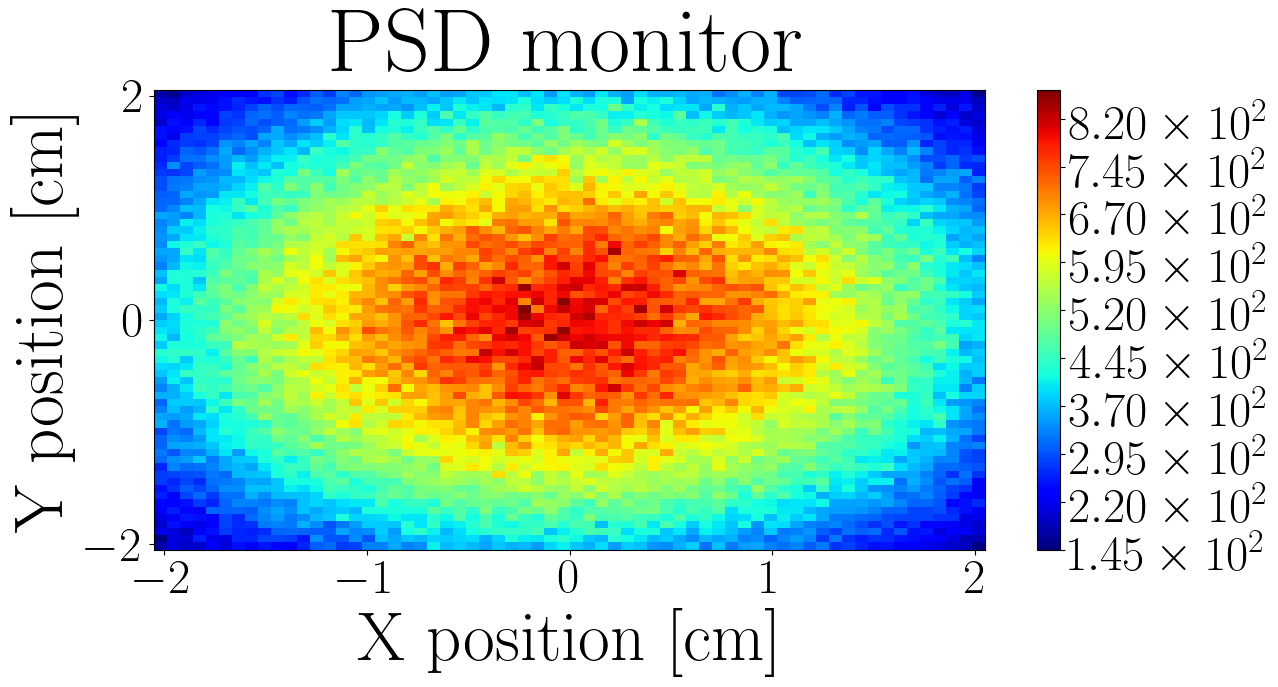

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_lc_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy CC_NRSE.instr in dataset C:\Users\samck\Documents\Scr

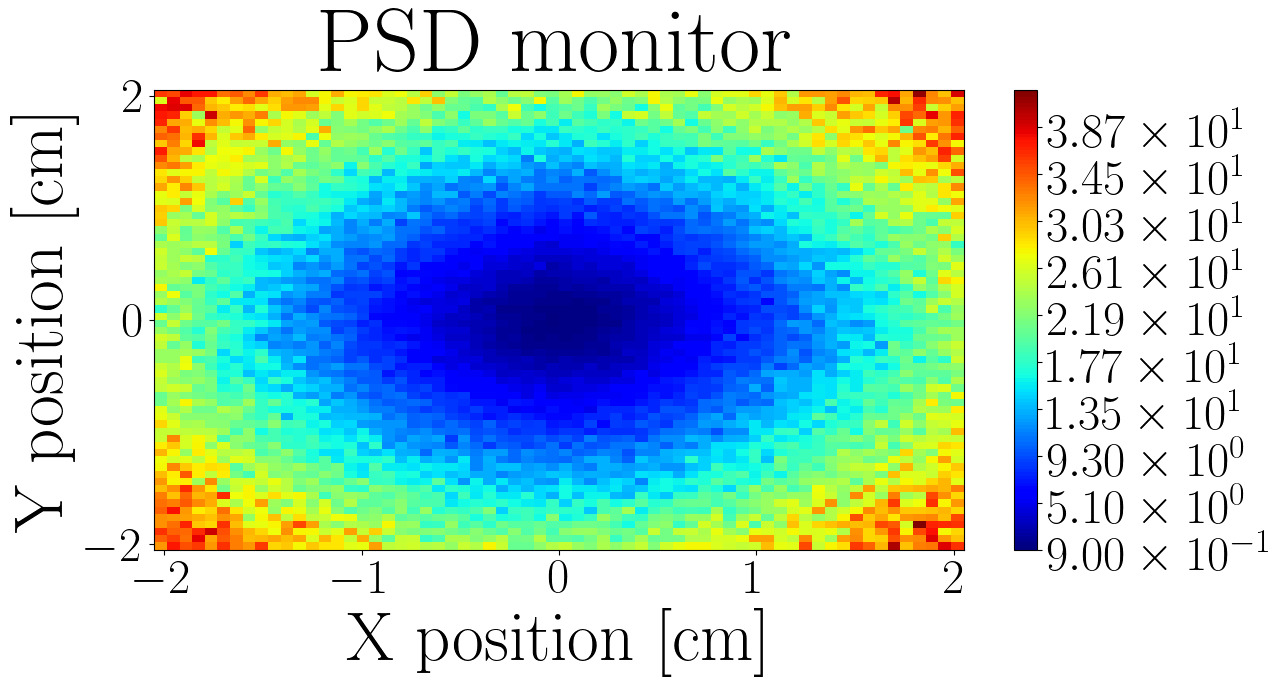

=== Devices that are on:  ['CC1', 'RF', 'Sam'] ===
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_hc_CC1_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file cop

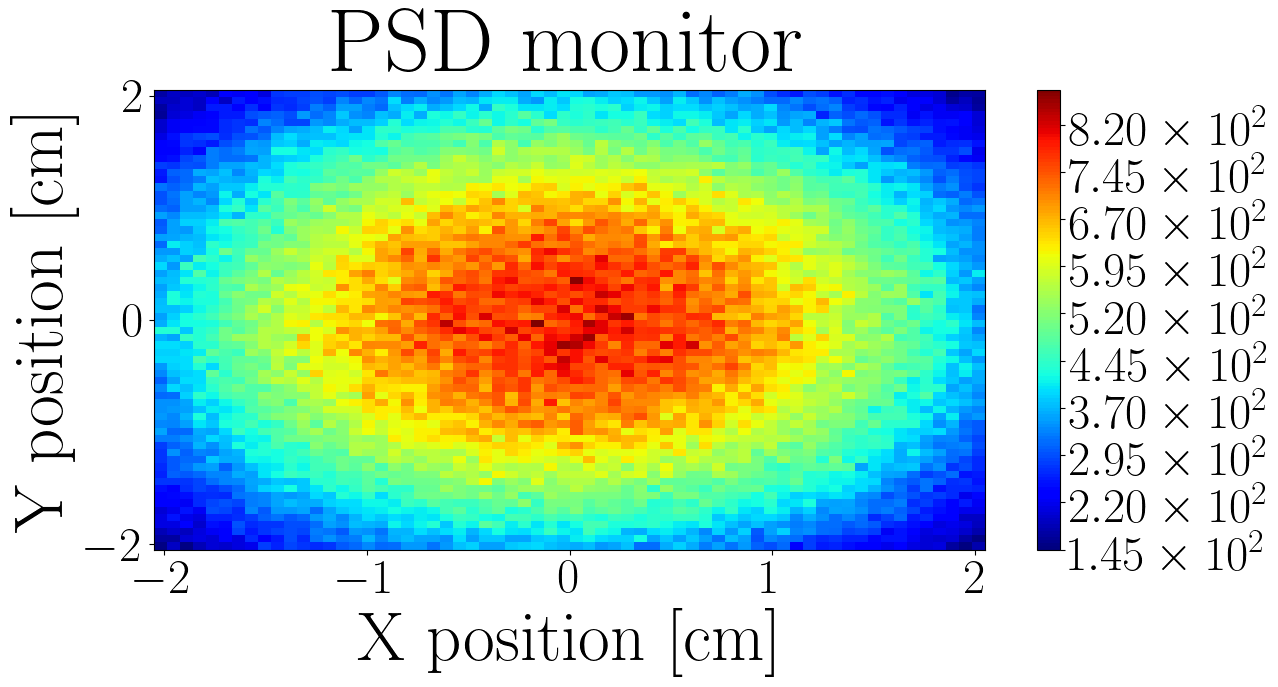

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_lc_CC1_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy CC_NRSE.instr in dataset C:\Users\samck\Documents

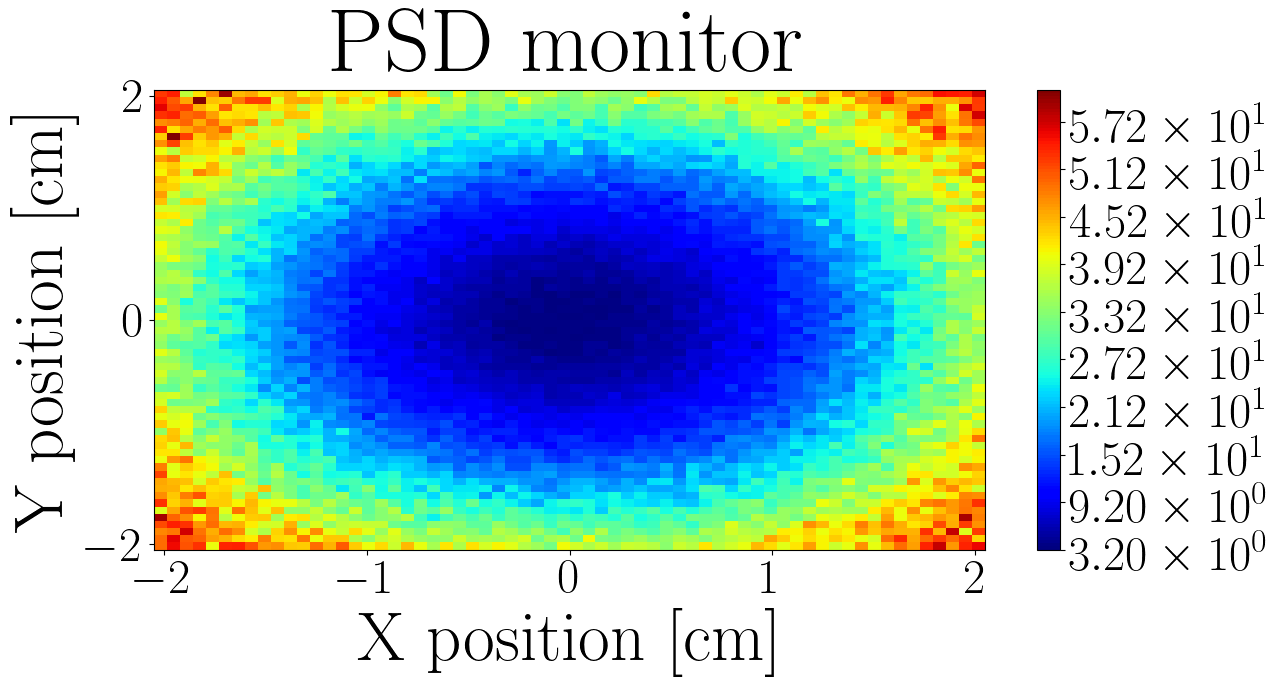

=== Devices that are on:  ['CC2', 'RF', 'Sam'] ===
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_hc_CC2_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file cop

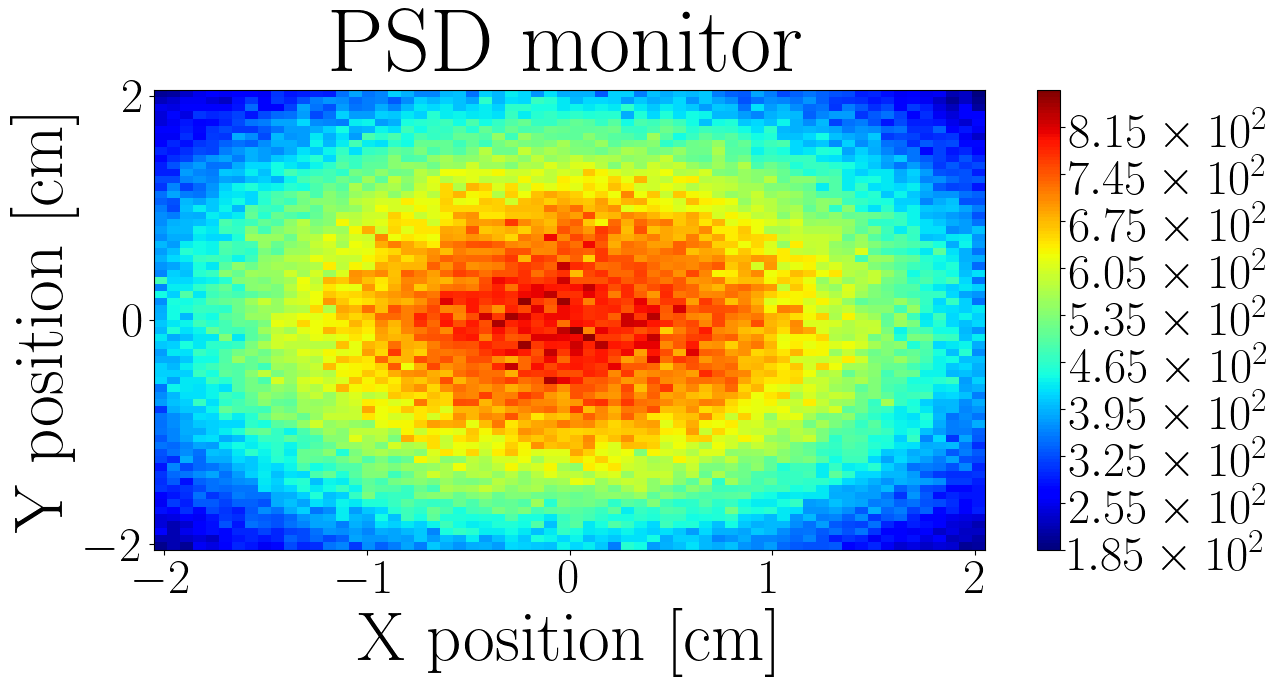

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_lc_CC2_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy CC_NRSE.instr in dataset C:\Users\samck\Documents

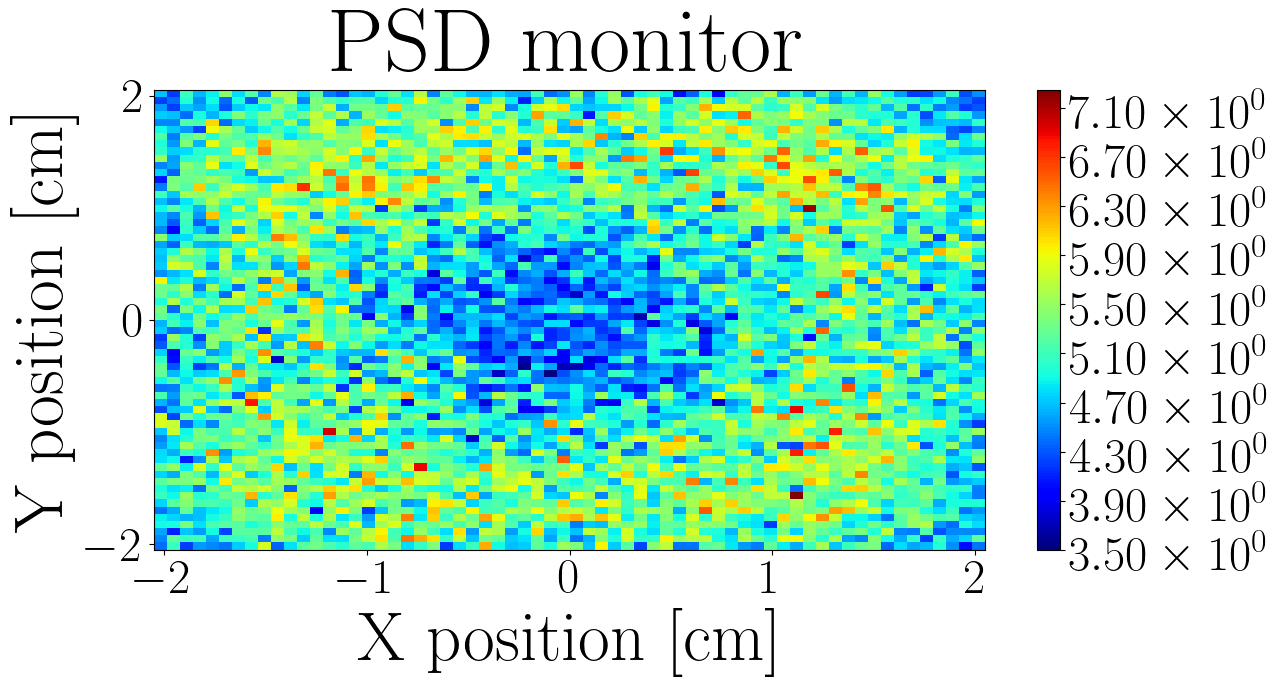

=== Devices that are on:  ['CC1', 'CC2', 'RF', 'Sam'] ===
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_hc_CC1_CC2_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing ins

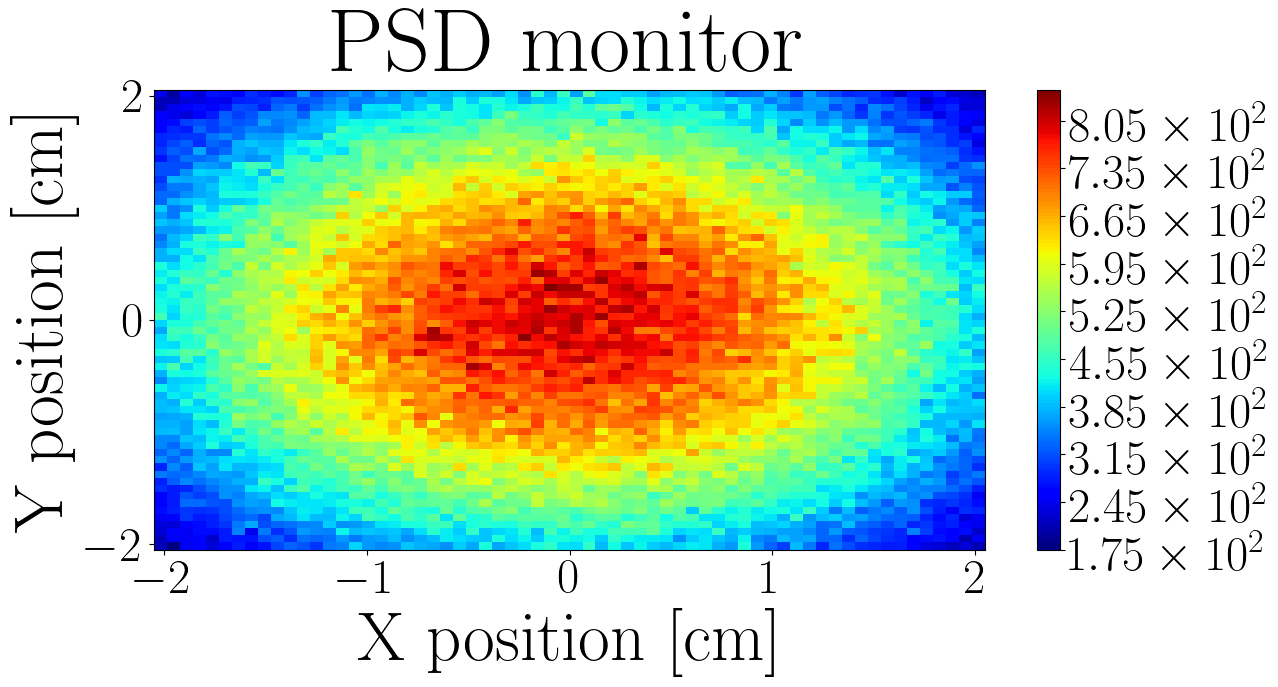

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\NRSE_v4\NRSE_CC_lc_CC1_CC2_RF_Sam"
INFO: Regenerating c-file: CC_NRSE.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_RFaker' is a contributed component.
Info:    'pol_CC_expansion_v4' is a contributed component.
CFLAGS=
INFO: Recompiling: CC_NRSE.exe
CC_NRSE.c: In function 'mcuse_dir':
CC_NRSE.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
CC_NRSE.c: In function 'sighandler':
CC_NRSE.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy CC_NRSE.instr in dataset C:\Users\samck\Docum

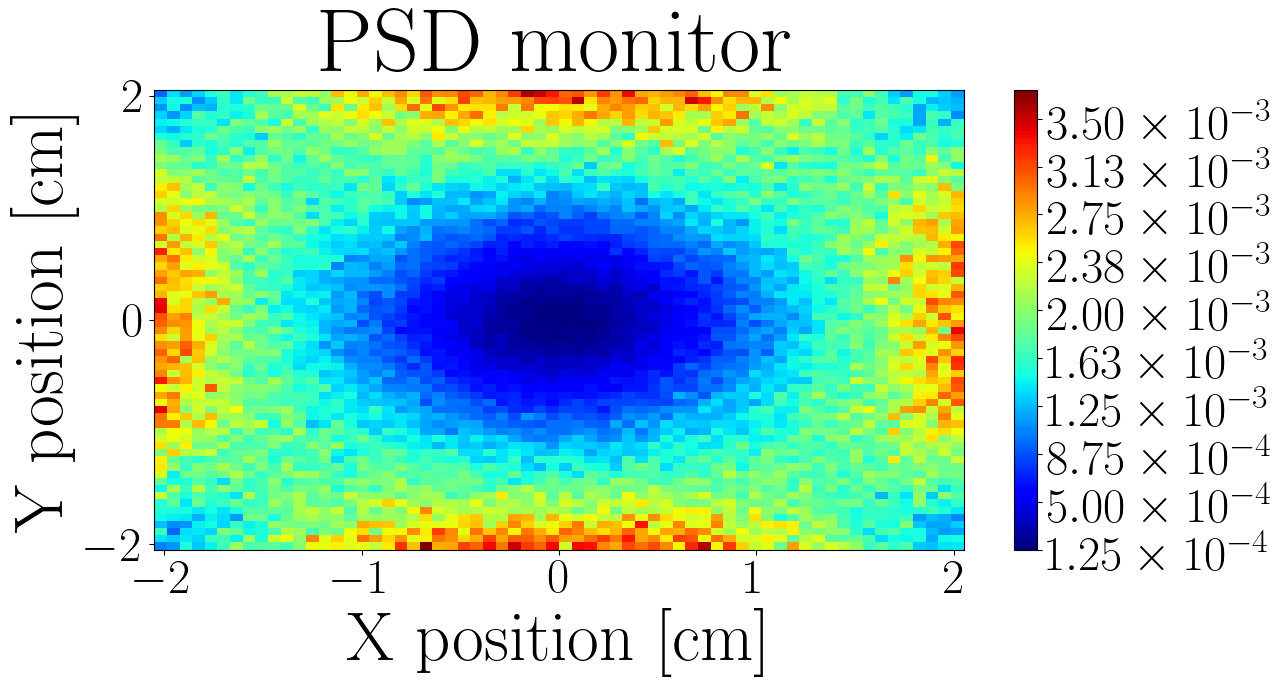

In [11]:
ray_num = 1e7

def get_run_list(run_index):
    """Returns a list of strings of which components were turned on.
    Given list must have 4 elements: cc_arm1, cc_arm2, rf, sample."""
    runs = []
    if(run_index[0]):
        runs.append('CC1')
    if(run_index[1]):
        runs.append('CC2')
    if(run_index[2]):
        runs.append('RF')
    if(run_index[3]):
        runs.append('Sam')
    return runs

def do_run(ray_num, run_index):
    """Performs McStas simulation. Returns high/low counts with errors with runlist."""
    run_list = get_run_list(run_index)
    print("=== Devices that are on: ", run_list, "===")
    arm1_on.value, arm2_on.value, rf_on.value, sample_in.value = run_index
    arm2_angle = 0.0
    ang_s.value = arm2_angle
    low_count.value = 0
    
    NRSE.settings(output_path='NRSE_CC_hc_'+"_".join(run_list), ncount=ray_num)
    NRSE_hc = NRSE.backengine()
    hc_run, hc_err = NRSE_hc[0].Intensity, NRSE_hc[0].Error
    ms.make_sub_plot(NRSE_hc)
    
    if (not any(run_list)):    #skips low count run for empty beamline
        return hc_run, hc_err, [], [], run_list
    else:
        low_count.value = 1
        NRSE.settings(output_path='NRSE_CC_lc_'+"_".join(run_list), ncount=ray_num)
        NRSE_lc = NRSE.backengine()
        lc_run, lc_err = NRSE_lc[0].Intensity, NRSE_lc[0].Error
        ms.make_sub_plot(NRSE_lc)
        return hc_run, hc_err, lc_run, lc_err, run_list

runs = [[0,0,1,1], [1,0,1,1], [0,1,1,1], [1,1,1,1]]    #controls simulation
results = [[] for i in range(len(runs))]
for indx,r in enumerate(runs):
    results[indx] = do_run(ray_num, r)
    print('='*80)

### Polarization extraction for constant wavelength

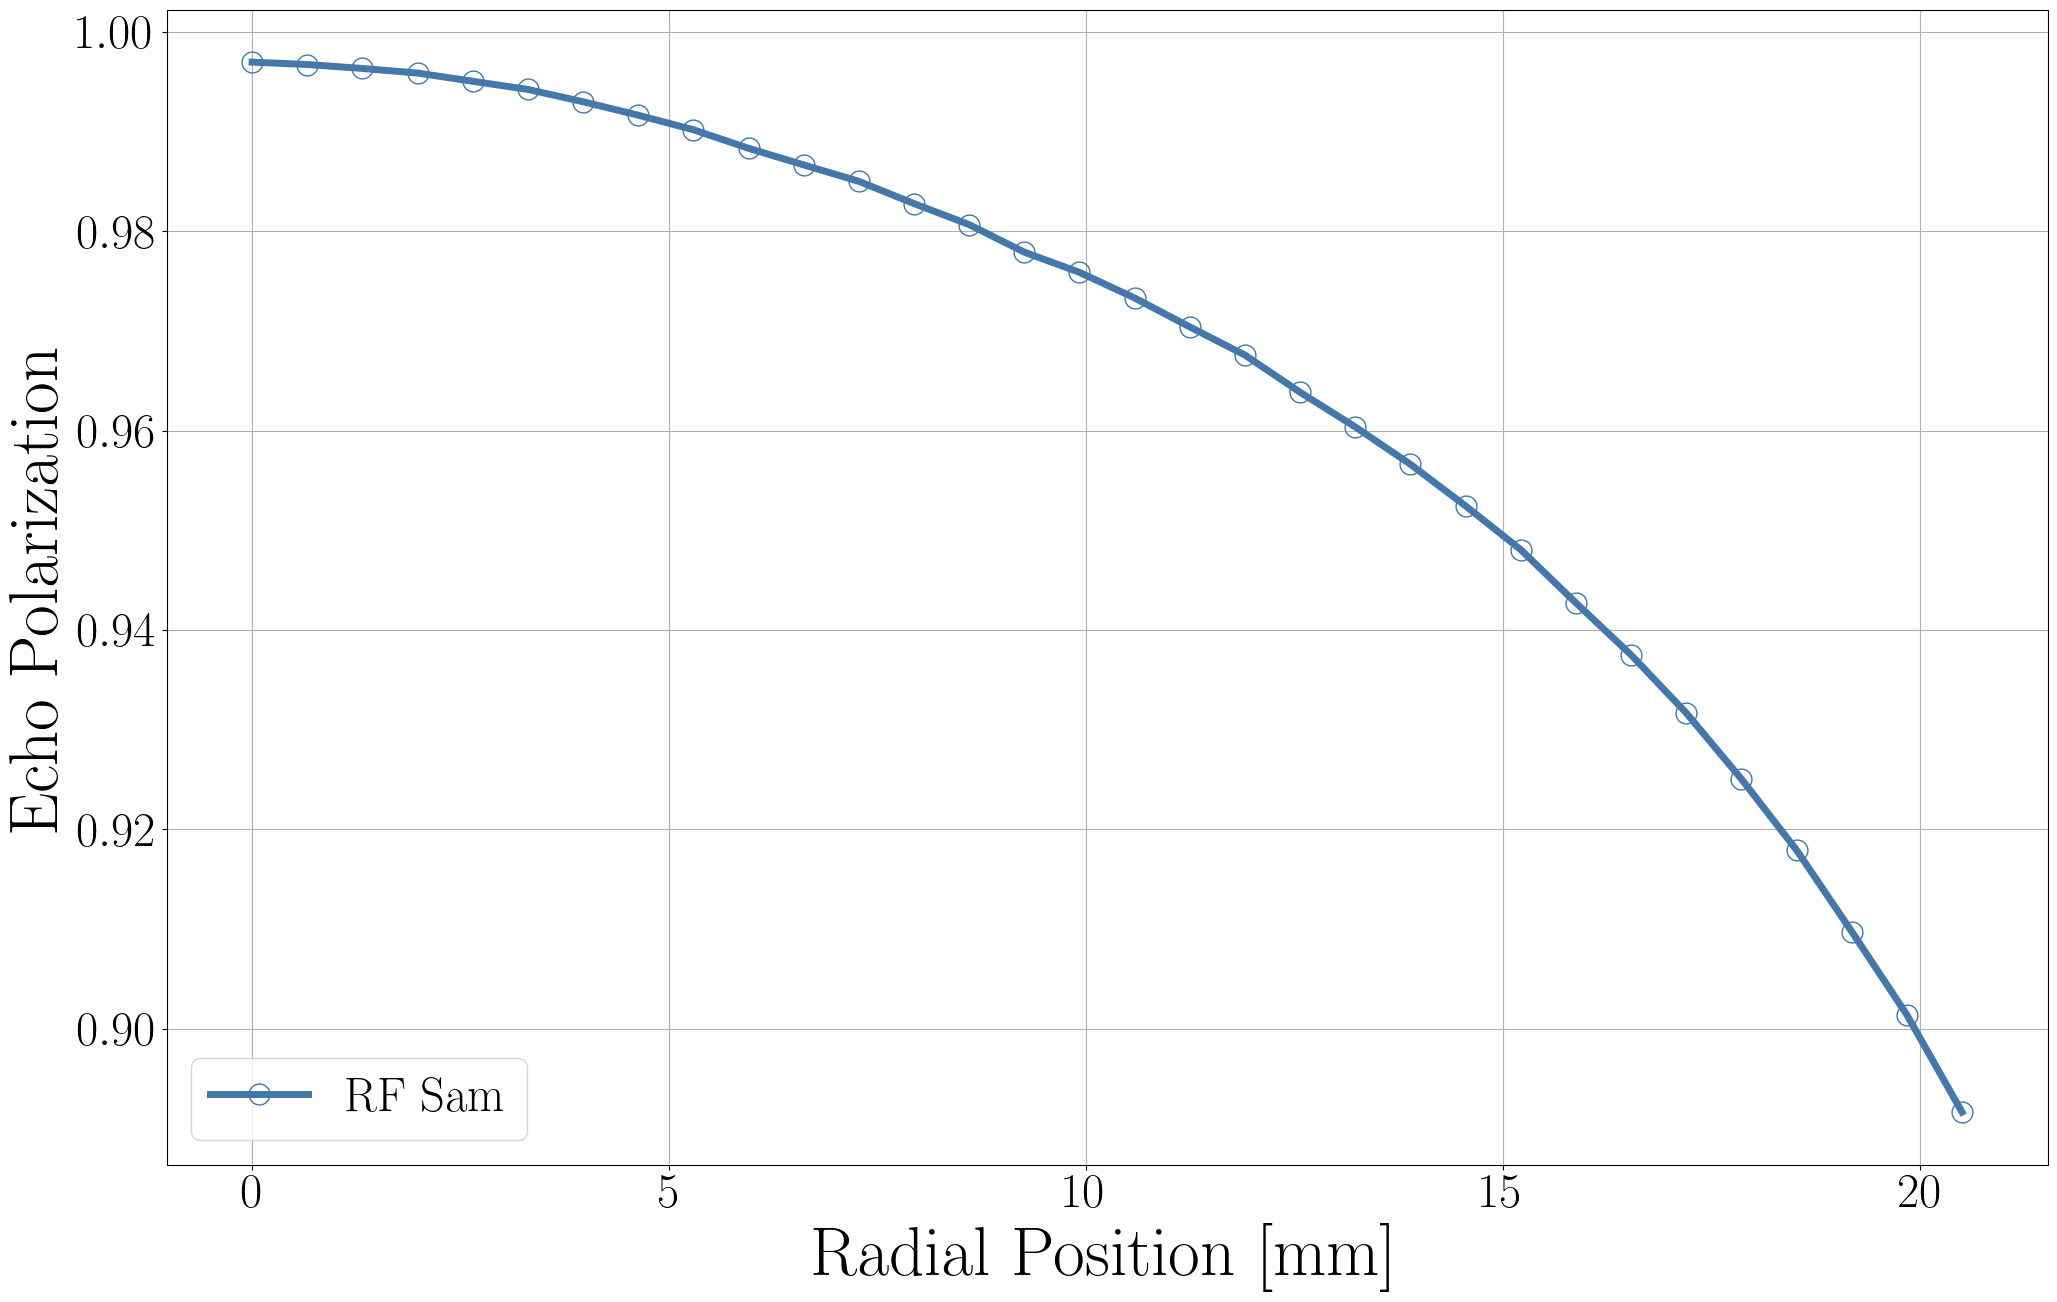

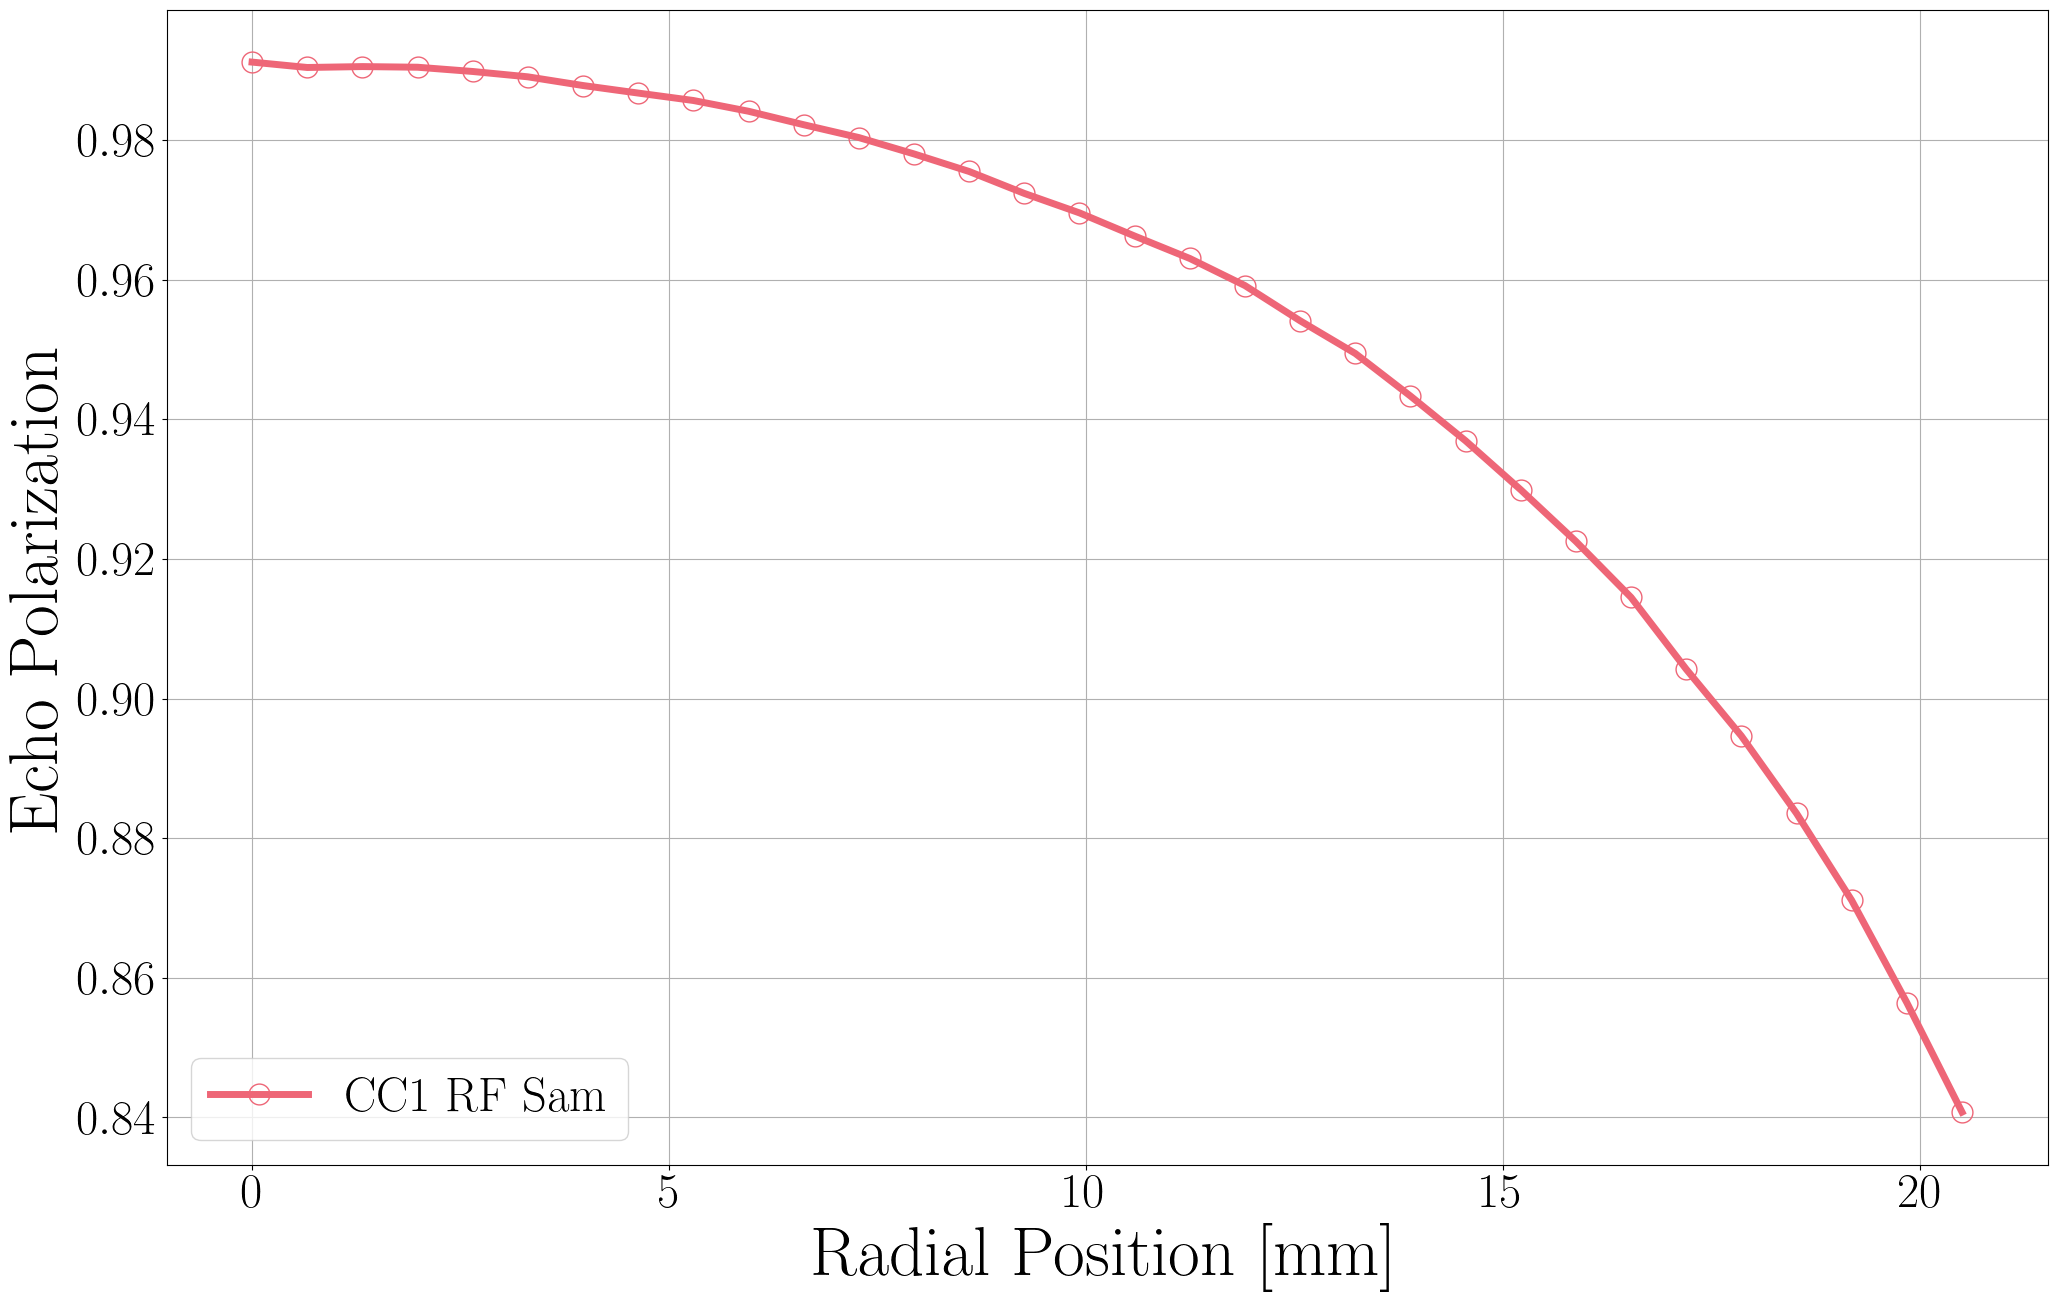

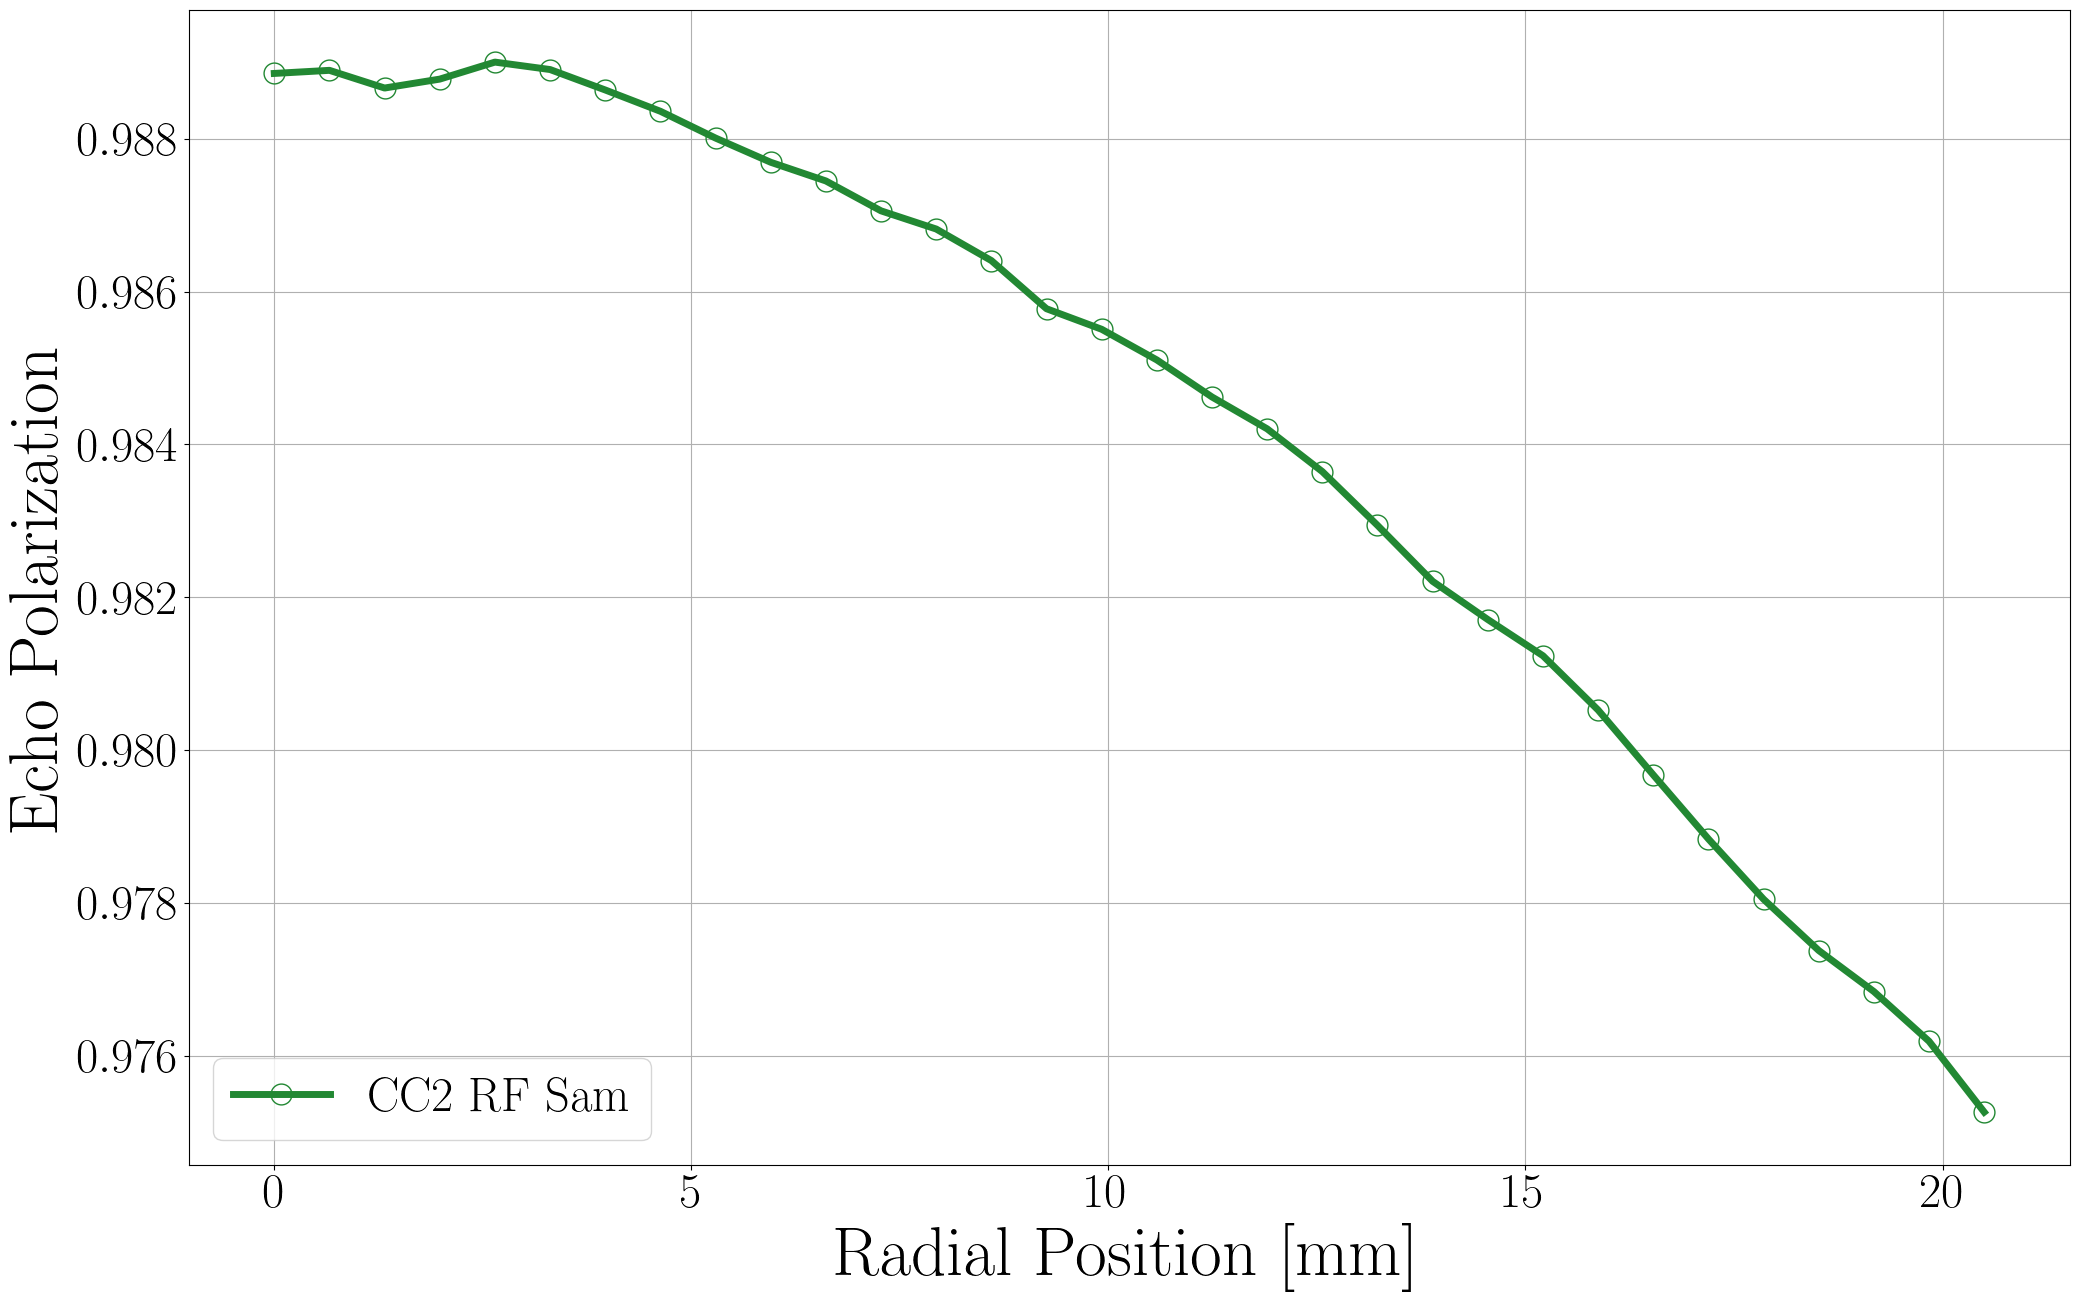

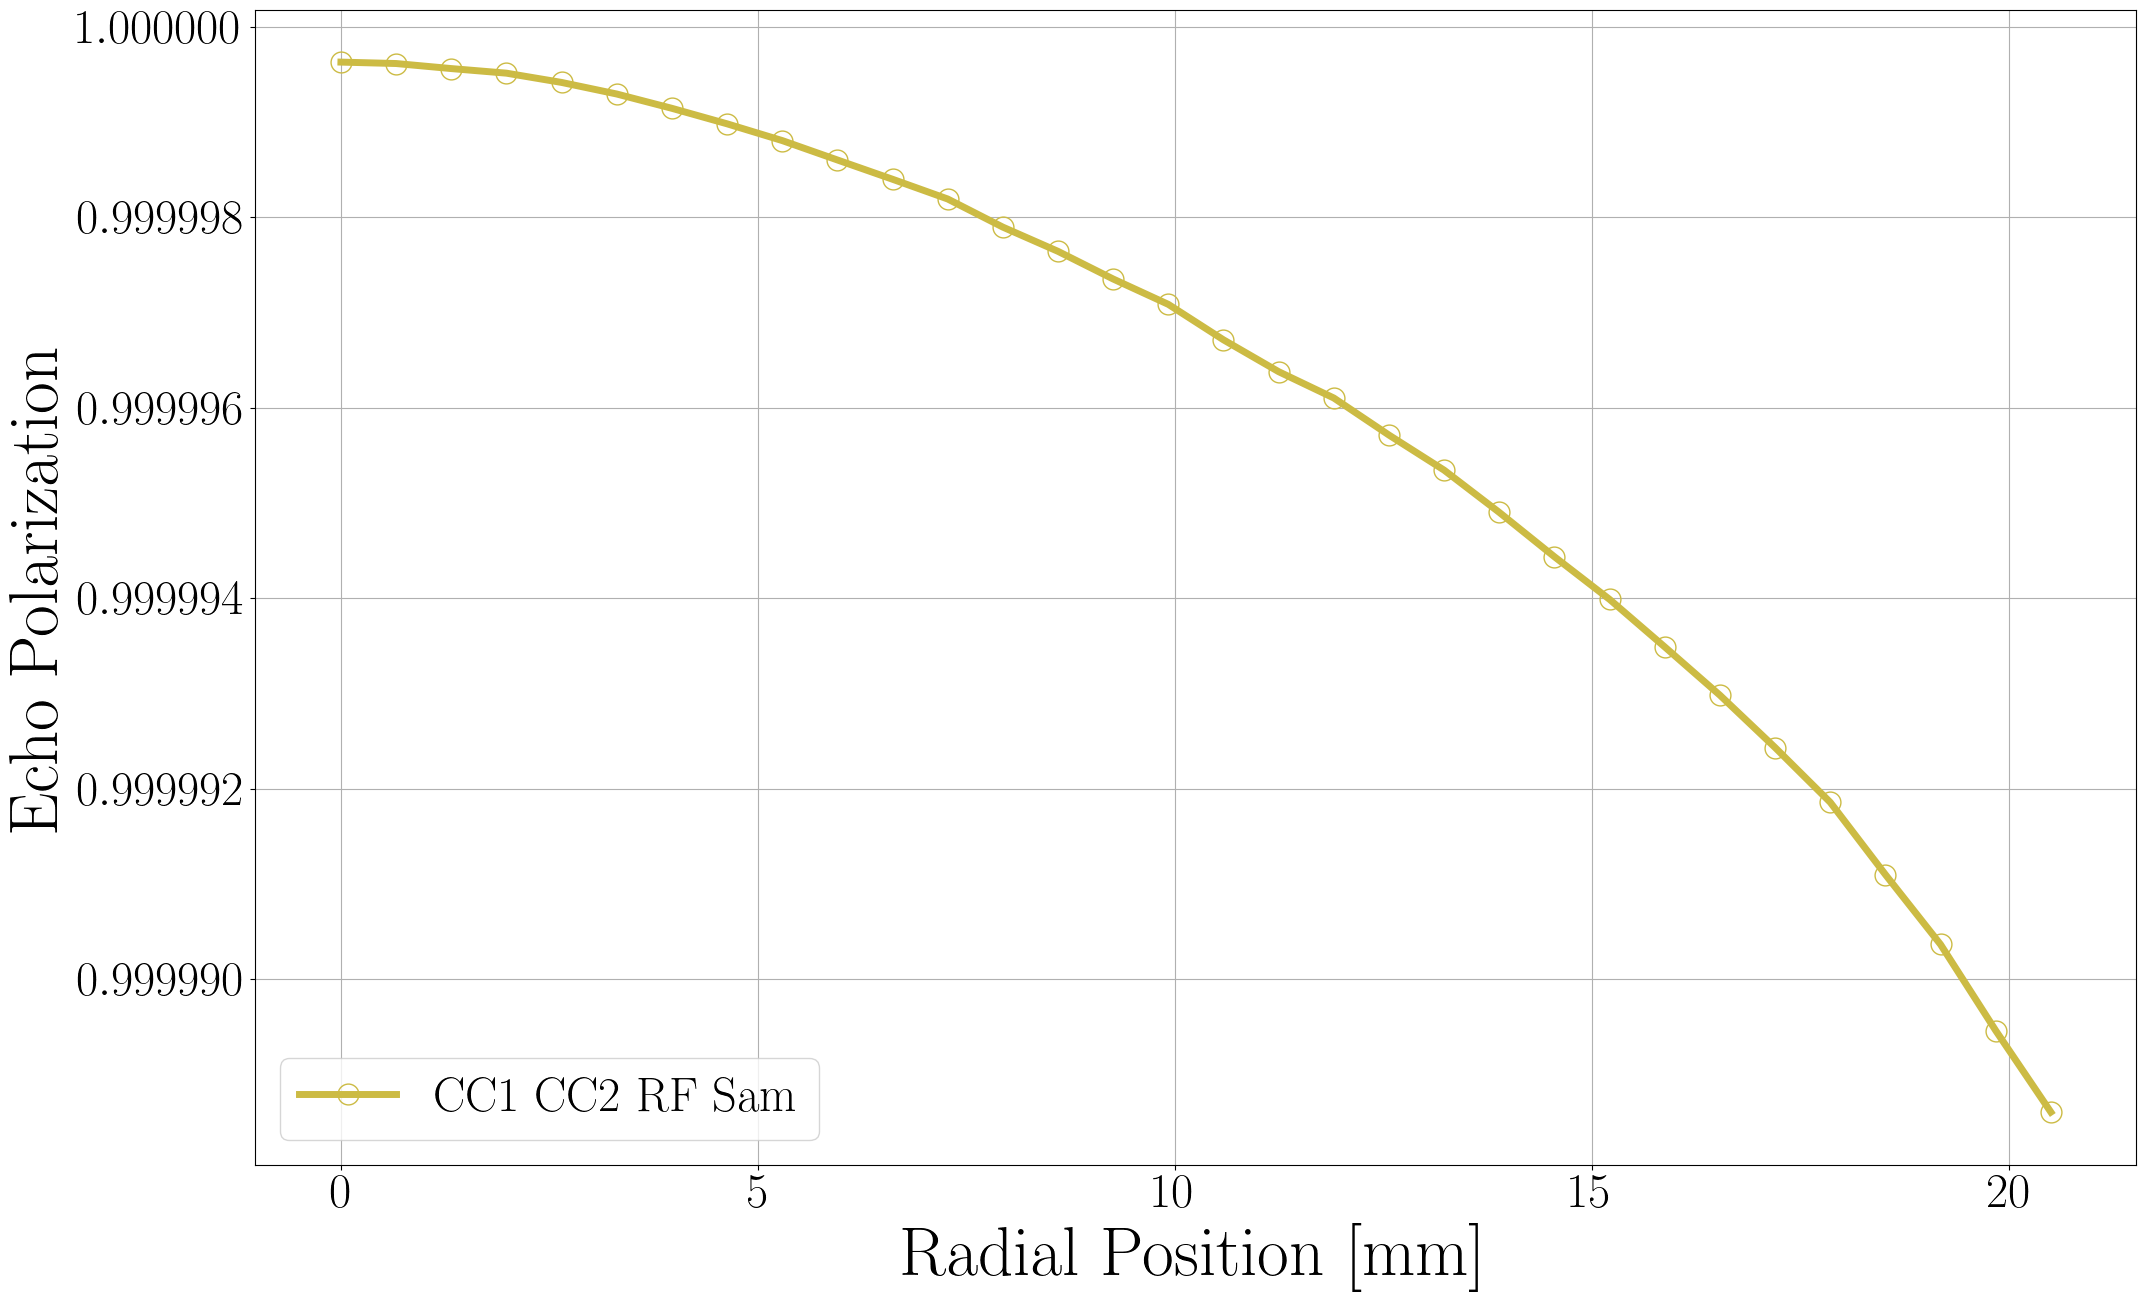

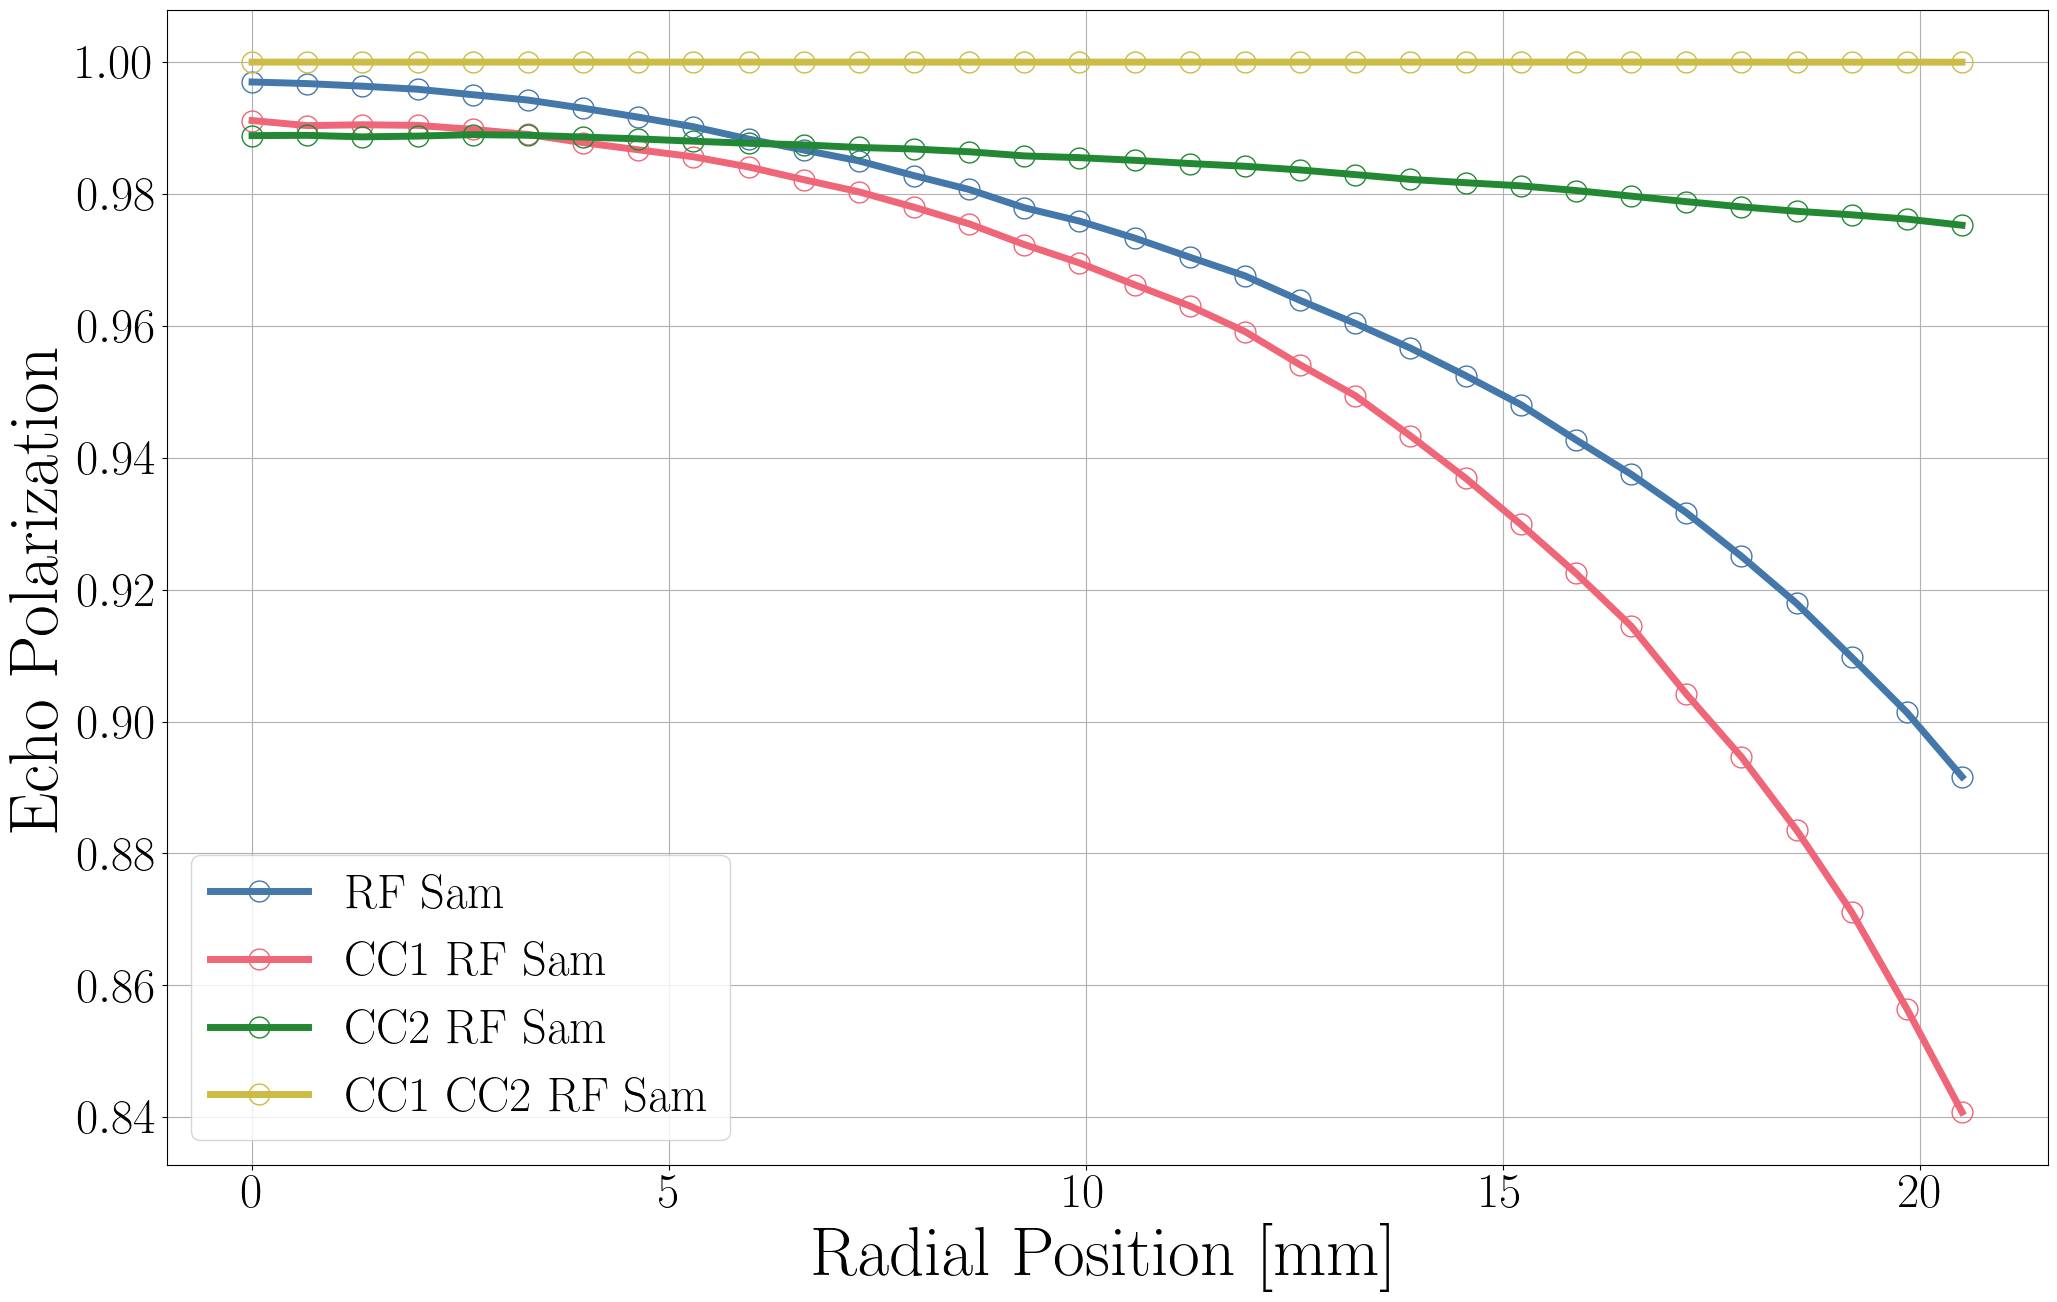

In [44]:
data_pols_2d = []    #hold 2D polarization for each run
for i in range(len(runs)):
    data_pols_2d.append((results[i][0] - results[i][2])/(results[i][0] + results[i][2]))
    
xpos = np.linspace(xmin, xmax, det_bins)    #horizontal position (mm)

rad_bins = int(det_bins/2.0)    #bin number for radial averaging
rpos = np.linspace(0, xmax, rad_bins)    #radial position (mm)
delta_r = xmax/rad_bins    #length of each radial bin (mm)

Rvals = np.empty((det_bins, det_bins))    #distances from center for each pixel (x,y) in pixels
for x in range(det_bins):    #Calculates distance from center for each pixel (x,y) in pixels
    for y in range(det_bins):
        Rvals[x][y] = np.sqrt((x - center)**2 + (y - center)**2)

Av_I = np.array([np.zeros(rad_bins) for i in range(len(runs))])    #average radial intensities (mm)
rad_av_width = 2    #full width of annular region used for averaging in pixels

for i in range(len(runs)):    #polarization vs radial position individually
    for r in range(len(Av_I[i])):    #Loop performs radial average
        mask = (np.greater(Rvals, r - rad_av_width/2) & np.less(Rvals, r + rad_av_width/2))    #annular mask
        values = data_pols_2d[i][mask]    #applies mask to the data
        if len(values)>0:
            Av_I[i][r] = np.mean(values)     #averages data found in the annular mask region
        else:
            print("Error: Annular mask failed!", runs[i], "r = ", r)
            Av_I[i][r] = 0.0
    ax = plt.subplot(111)
    plt.plot(rpos, Av_I[i], 'o-', fillstyle='none', ms=15, linewidth=5, color='C' + str(i), label=" ".join(results[i][4]))
    plt.legend(loc='lower left')
    plt.xlabel('Radial Position [mm]')
    plt.ylabel('Echo Polarization')
    plt.grid('On')
    ax.ticklabel_format(useOffset=False)
    #print("Polarization Values: ", Av_I[i])    #used for debugging
    plt.show()

runs_to_plot = [0,1,2,3]
ax = plt.subplot(111)    #overlays multiple plots of polarization vs radial position
for i in runs_to_plot:
    #plot_label = runs[i] + ", CC=" + str(round(used_curs[i],5))
    plt.plot(rpos, Av_I[i], 'o-', fillstyle='none', ms=15, linewidth=5, color='C' + str(i), label=" ".join(results[i][4]))
ax.ticklabel_format(useOffset=False)
ax.legend(loc='lower left')
plt.xlabel('Radial Position [mm]')
plt.ylabel('Echo Polarization')
plt.grid('On')

### Polarization extraction for polychromatic beam (To do)

In [219]:
#Polarization extraction for time of flight
#WARNING: cell out of date! Will not run

data_pols = (data_high[1].Intensity - data_low[1].Intensity)/(data_high[1].Intensity + data_low[1].Intensity)

tof = np.linspace(time_min/1000, time_max/1000, time_bins)    #Time of flight array (ms)
wav = np.asarray([hbar*2*np.pi/L_d*i/1000/mN*10**10 for i in tof])    #Wavelength array (AA)

def simple_cos(x, a0, f0, f1):    #used for the wavelength polarization "scan"
    return a0*np.cos(f0 + f1*x)

mc_amp_b_1d = 1.1    #multiplicative bound on amplitude
mc_phase_b_1d = 2*np.pi    #additive bound on phase
mc_freq_b_1d = 5    #additive bound on frequency

mc_amp_est_1d = (abs(max(data_pols)) + abs(min(data_pols)))/2
mc_phase_est_1d = 0.0
mc_freq_est_1d = 2*np.pi/0.2

parms, cov = curve_fit(simple_cos, wav, data_pols, p0=(mc_amp_est_1d, mc_phase_est_1d, mc_freq_est_1d), bounds=([mc_amp_est_1d/mc_amp_b_1d, mc_phase_est_1d - mc_phase_b_1d, mc_freq_est_1d - mc_freq_b_1d], [mc_amp_est_1d*mc_amp_b_1d, mc_phase_est_1d +  mc_phase_b_1d, mc_freq_est_1d + mc_freq_b_1d]))
a0, f0, f1 = parms
fitted = simple_cos(wav,a0,f0,f1)

print("Parameters: ", [round(i, 5) for i in parms], "\n")
print("Errors: ", [round(np.sqrt(k),5) for k in np.diag(cov)], "\n")

#Plots polarization vs wavelength
plt.figure(figsize=(plot_height*grat,plot_height))
plt.plot(wav, data_pols, 'o', fillstyle='none', ms=4)
plt.plot(wav, fitted, '-', fillstyle='none', ms=4)
plt.xlabel('Wavelength [A]')
plt.ylabel('Polarization')
plt.grid('On')

mc_freq_est_1d = 2*np.pi/0.35

parms, cov = curve_fit(simple_cos, tof, data_pols, p0=(mc_amp_est_1d, mc_phase_est_1d, mc_freq_est_1d), bounds=([mc_amp_est_1d/mc_amp_b_1d, mc_phase_est_1d - mc_phase_b_1d, mc_freq_est_1d - mc_freq_b_1d], [mc_amp_est_1d*mc_amp_b_1d, mc_phase_est_1d +  mc_phase_b_1d, mc_freq_est_1d + mc_freq_b_1d]))
a0, f0, f1 = parms
fitted = simple_cos(tof,a0,f0,f1)

print("Parameters: ", [round(i, 5) for i in parms], "\n")
print("Errors: ", [round(np.sqrt(k),5) for k in np.diag(cov)], "\n")

#Plots polarization vs time of flight
plt.figure(figsize=(plot_height*grat,plot_height))
plt.plot(tof, data_pols, 'o', fillstyle='none', ms=4)
plt.plot(tof, fitted, '-', fillstyle='none', ms=4)
plt.xlabel('Time of Flight [ms]')
plt.ylabel('Polarization')
plt.grid('On')

7.300061902465985